**Generative Adversarial Network (GAN)**

This project implements a Generative Adversarial Network (GAN) from scratch using PyTorch to generate synthetic images that resemble the real images from the CIFAR-10 dataset.
The CIFAR-10 dataset contains 60,000 color images (32×32 pixels) divided into 10 classes, such as airplanes, automobiles, birds, cats, dogs, and horses.
The main objective of this project is to train a GAN model that can learn the underlying data distribution of CIFAR-10 and generate new, realistic-looking images that mimic real samples from the dataset.

**Importing Required Libraries**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Defining Image Transformations**

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

**Loading the CIFAR-10 Dataset**

In [3]:
train_dataset = datasets.CIFAR10(root='./data',\
              train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(train_dataset, \
                                batch_size=32, shuffle=True)

100%|██████████| 170M/170M [00:06<00:00, 28.4MB/s]


**Defining GAN Hyperparameters**

In [4]:
latent_dim = 100
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
num_epochs = 10

**Building the Generator**

In [5]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128 * 8 * 8),
            nn.ReLU(),
            nn.Unflatten(1, (128, 8, 8)),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128, momentum=0.78),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64, momentum=0.78),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img

**Building the Discriminator**

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.25),
        nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
        nn.ZeroPad2d((0, 1, 0, 1)),
        nn.BatchNorm2d(64, momentum=0.82),
        nn.LeakyReLU(0.25),
        nn.Dropout(0.25),
        nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(128, momentum=0.82),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.25),
        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256, momentum=0.8),
        nn.LeakyReLU(0.25),
        nn.Dropout(0.25),
        nn.Flatten(),
        nn.Linear(256 * 5 * 5, 1),
        nn.Sigmoid()
    )

    def forward(self, img):
        validity = self.model(img)
        return validity

**Initializing GAN Components**

In [7]:
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

adversarial_loss = nn.BCELoss()

optimizer_G = optim.Adam(generator.parameters()\
                         , lr=lr, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters()\
                         , lr=lr, betas=(beta1, beta2))

**Training the GAN**

Epoch [1/10]                        Batch 100/1563 Discriminator Loss: 0.5218 Generator Loss: 1.3035
Epoch [1/10]                        Batch 200/1563 Discriminator Loss: 0.6223 Generator Loss: 1.0866
Epoch [1/10]                        Batch 300/1563 Discriminator Loss: 0.6121 Generator Loss: 0.9777
Epoch [1/10]                        Batch 400/1563 Discriminator Loss: 0.6398 Generator Loss: 0.9495
Epoch [1/10]                        Batch 500/1563 Discriminator Loss: 0.7294 Generator Loss: 1.0039
Epoch [1/10]                        Batch 600/1563 Discriminator Loss: 0.6861 Generator Loss: 1.0146
Epoch [1/10]                        Batch 700/1563 Discriminator Loss: 0.6169 Generator Loss: 0.9620
Epoch [1/10]                        Batch 800/1563 Discriminator Loss: 0.6618 Generator Loss: 0.8845
Epoch [1/10]                        Batch 900/1563 Discriminator Loss: 0.6685 Generator Loss: 0.9145
Epoch [1/10]                        Batch 1000/1563 Discriminator Loss: 0.5622 Generator Lo

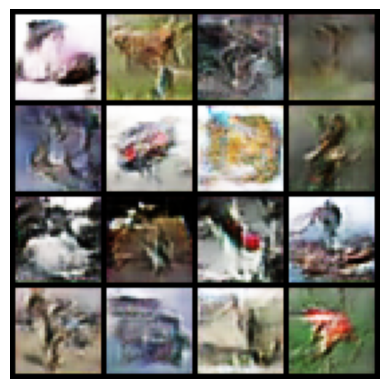

In [8]:
for epoch in range(num_epochs):
    for i, batch in enumerate(dataloader):

        real_images = batch[0].to(device)

        valid = torch.ones(real_images.size(0), 1, device=device)
        fake = torch.zeros(real_images.size(0), 1, device=device)

        real_images = real_images.to(device)

        optimizer_D.zero_grad()

        z = torch.randn(real_images.size(0), latent_dim, device=device)

        fake_images = generator(z)

        real_loss = adversarial_loss(discriminator\
                                     (real_images), valid)
        fake_loss = adversarial_loss(discriminator\
                                     (fake_images.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()

        gen_images = generator(z)

        g_loss = adversarial_loss(discriminator(gen_images), valid)
        g_loss.backward()
        optimizer_G.step()

        if (i + 1) % 100 == 0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}]\
                        Batch {i+1}/{len(dataloader)} "
                f"Discriminator Loss: {d_loss.item():.4f} "
                f"Generator Loss: {g_loss.item():.4f}"
            )
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            z = torch.randn(16, latent_dim, device=device)
            generated = generator(z).detach().cpu()
            grid = torchvision.utils.make_grid(generated,\
                                        nrow=4, normalize=True)
            plt.imshow(np.transpose(grid, (1, 2, 0)))
            plt.axis("off")
            plt.show()

**Conclusion**

In this project, we successfully implemented and trained a Generative Adversarial Network (GAN) using PyTorch to generate synthetic images from the CIFAR-10 dataset.
The GAN consisted of two neural networks — a Generator and a Discriminator — engaged in a competitive learning process where the generator aimed to produce realistic images, and the discriminator attempted to distinguish fake images from real ones.

Throughout training, the generator progressively improved its ability to produce images that resemble natural scenes and objects from the CIFAR-10 dataset. The discriminator, in turn, became more adept at detecting fake samples, forcing the generator to refine its outputs further.

After around 10 epochs of training, the generated images began showing recognizable patterns and colors that loosely resembled real CIFAR-10 categories (such as animals, vehicles, and nature scenes). Although the samples remained blurry and lacked fine details, the results confirmed that the model had successfully learned the underlying data distribution of the dataset to some extent.

The observed training losses showed the expected adversarial behavior — with the discriminator loss fluctuating between 0.4 and 0.9 and the generator loss oscillating between 0.8 and 1.5 — indicating that the two networks were actively competing rather than one dominating the other.